In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "."                                                                                 

In [2]:
using ExoJulia
using Optim
using LsqFit

In [3]:
using PyPlot

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read-in TTV data

In [4]:
ttv1_data = readdlm("../ttv_planet1.txt");
ttv2_data = readdlm("../ttv_planet2.txt");

In [5]:
# Reshape into 1d arrays
time1 = reshape(ttv1_data, length(ttv1_data));
time2 = reshape(ttv2_data, length(ttv2_data));

In [6]:
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

mdt1 = mean(dt1);
mdt2 = mean(dt2);

bestP1 = mdt1;
bestP2 = mdt2;

stdt1 = std(dt1);
stdt2 = std(dt2);

print("Inner planet period: ", mdt1, " +/- ", stdt1, "\n")
print("Outer planet period: ", mdt2, " +/- ", stdt2)

Inner planet period: 224.70076641863517 +/- 0.0022854502193227965
Outer planet period: 365.25630708152175 +/- 0.002178896306975526

In [7]:
function period_from_times(time::Array{Float64, 1})

    # Delta t between transits 
    dt = time[2:end] - time[1:end-1];
    
    # Mean time between transits --> Period!
    mdt = mean(dt);
    
    # Standard deviation of time between transits 
    # --> on order of TTV
    stdt = std(dt);

    #print("Planet period: ", mdt, " +/- ", stdt, "\n")
    
    return mdt, stdt
end

period_from_times (generic function with 1 method)

In [8]:
bestP1, std1 = period_from_times(time1)
bestP2, std2 = period_from_times(time2)

(365.25630708152175,0.002178896306975526)

In [9]:
tt01 = time1[1]
tt02 = time2[1]

8461.757350445

# Plot Data

In [10]:
function ttvs_from_times(times, P)
    # Construct time array on planet period
    a1 = ones(length(times))
    for i=1:length(times)
        a1[i] = (i-1)*P
    end

    # TTV signal is: (Nth transit time) - N*(Orbital Period) - (time of first transit)
    ttv = (times .- a1) - times[1]
    return ttv
end 

ttvs_from_times (generic function with 1 method)

In [11]:
function times_from_ttvs(ttvs, P, t0)
    # Construct time array on planet period
    a1 = ones(length(ttvs))
    for i=1:length(ttvs)
        a1[i] = (i-1)*P
    end

    # (Nth transit time) = (TTV) + N*(Orbital Period) + (time of first transit)
    times = (ttvs .+ a1) + t0
    return times
end 

times_from_ttvs (generic function with 1 method)

In [12]:
obs_ttv1 = ttvs_from_times(time1, bestP1;)
obs_ttv2 = ttvs_from_times(time2, bestP2);

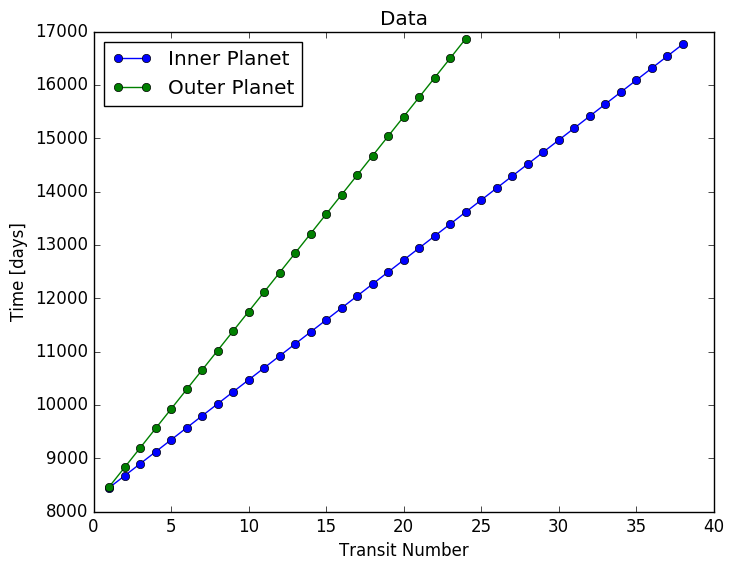

PyObject <matplotlib.legend.Legend object at 0x3253f7790>

In [13]:
times_test1 = times_from_ttvs(obs_ttv1, bestP1, time1[1])
times_test2 = times_from_ttvs(obs_ttv2, bestP2, time2[1])

plot(linspace(1,length(time1), length(time1)), time1, "o-", label="Inner Planet")
plot(linspace(1,length(time2), length(time2)), time2, "o-", label="Outer Planet")
ylabel("Time [days]")
xlabel("Transit Number")
title("Data")
legend(loc=2)

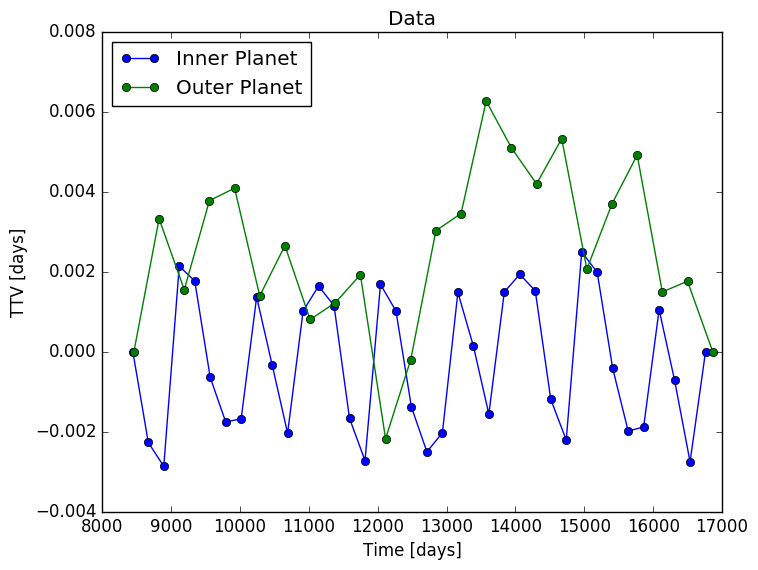

PyObject <matplotlib.legend.Legend object at 0x325425fd0>

In [14]:
obs_ttv1 = ttvs_from_times(time1, bestP1)
obs_ttv2 = ttvs_from_times(time2, bestP2)

plot(time1, obs_ttv1, "o-", label="Inner Planet")
plot(time2, obs_ttv2, "o-", label="Outer Planet")
ylabel("TTV [days]")
xlabel("Time [days]")
title("Data")
legend(loc=2)

# Wrapper for `compute_ttv.jl`

In [15]:
include("../compute_ttv.jl")

TTVFaster

In [16]:
#planet1
MpMs1 = 0.001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

planet_test = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)

p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];

In [17]:
function construct_planets(params::Vector)
    
    # NOTE: 5 model parameters per planet
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params. Must be multiple of 5!")
        return nothing
    else
        N = Int(length(params) / 5)
        # Construct Planet grid
        plist = []
        for i=1:N
            push!(plist, TTVFaster.Planet_plane_hk(params[5*(i-1)+1], 
                                                   params[5*(i-1)+2], 
                                                   params[5*(i-1)+3], 
                                                   params[5*(i-1)+4],
                                                   params[5*(i-1)+5]))
        end 
    end 
    return plist
end

construct_planets (generic function with 1 method)

In [18]:
planets_test = construct_planets(p0)

2-element Array{Any,1}:
 TTVFaster.Planet_plane_hk{Float64}(0.001,224.70076641863517,1.0,0.1,0.1)
 TTVFaster.Planet_plane_hk{Float64}(0.001,365.25630708152175,1.0,0.1,0.1)

In [19]:
function construct_planet_phase_times(tti::Array{Float64,1}, 
                                      Pj::Float64, 
                                      t0j::Float64)
    # Computes 'transit times' of non-transiting planet j
    
    # Duration over which planet i transits were observed:
    obs_duration = tti[end] - tti[1]
    
    # Number of planet j transits over that duration:
    Ntj = Int(round(obs_duration / Pj))
    
    # Transit times of planet j (shifted by t0)
    if Ntj == 1
        ttj = [tti[1] .+ t0j]
    else
        ttj = collect(linspace(0.0,obs_duration, Ntj)) .+ tti[1] .+ t0j
    end 
    
    return ttj
end

guessP3 = 4332.0
    t03 = 100.0
construct_planet_phase_times(time1, guessP3, t03)

2-element Array{Float64,1}:
  8545.5
 16859.4

In [20]:
# We're overloadding the crap out of the following function. No good reason for this :)

function deconstruct_data_grid(data::Array{Float64, 2}, 
                               i::Int64)
    # Removes zeros from grid and returns time grid for planets i
    
    # Number of planets with data
    N =  length(data[1,:])
    
    # Error check
    if i > N
        println("ERROR: Invalid i in deconstruct_data_grid(data, i)")
    end
    
    # Zero mask
    maski = data[:,i] .> 0.0
    
    # Extract arrays from data matrix
    timei = data[maski,i]
    
    return timei
end 

function deconstruct_data_grid(data::Array{Float64, 2}, 
                               i::Int64, 
                               j::Int64)
    # Removes zeros from grid and returns time grids for planets i & j

    # Extract arrays from data matrix
    timei = deconstruct_data_grid(data, i)
    timej = deconstruct_data_grid(data, j)
    
    return timei, timej
end 

function deconstruct_data_grid(data::Array{Float64, 2}; 
                               return_data::Bool=false)
    # This function takes a 2d data array and returns a list of data/zeros with unqeual lengths
  
    # Number of planets
    N =  length(data[1,:])
    
    # Mask columns with non-zero first element-- transiting planets!
    transiting = data[1,:] .> 0.0
    
    # Number of planets with transit data
    Nt = sum(transiting)
    
    # Allocate memory for ttv arrays
    ttv_list = []
    for i=1:length(transiting)
        # Only if transiting
        if transiting[i]
            if return_data
                # Get data
                tmp = deconstruct_data_grid(data, i)
            else
                # Set zeros
                len = sum(data[:,i] .> 0)
                tmp = zeros(len)
            end
            # Push to ttv_list
            push!(ttv_list, tmp)
        end
    end    
    
    return ttv_list, transiting
end 

deconstruct_data_grid (generic function with 3 methods)

In [21]:
function two_planet_ttv_model(time1::Array{Float64, 1},
                              time2::Array{Float64, 1}, 
                              planet1::TTVFaster.Planet_plane_hk{Float64}, 
                              planet2::TTVFaster.Planet_plane_hk{Float64};
                              jmax::Int64=5)
    # This model computes mutual TTVs between planet 1 & planet 2
    
    # Allocate memory for ttv's
    ttv1 = zeros(length(time1));
    ttv2 = zeros(length(time2));
    
    # Call compute_ttv! Note: modifies ttv1, ttv2 in place
    TTVFaster.compute_ttv!(jmax, planet1, planet2, time1, time2, ttv1, ttv2)

    return ttv1, ttv2
end 

two_planet_ttv_model (generic function with 1 method)

In [22]:
function N_planet_ttv_model(data::Array{Float64,2}, 
                            params::Vector)
    # This model computes the TTV signal of all specified planets, 
    # due to all other planets.
    # Returns a list of transit times arrays for all transiting planets.
    
    # Number of planets
    N =  length(data[1,:])
    
    # Create list for ttv model data, initialized with zeros.
    # Also returns boolean list for "if transiting?"
    ttv_list, transiting = deconstruct_data_grid(data; return_data=false)
    
    # Construct planet grid from params
    planets = construct_planets(params)
    
    # Loop over N(N-1) planets (no double counting), 
    # sum planet ttv contributions due to all other planets
    for i=1:N        
        for j=(i+1):N
            
            # Deconstruct data grid
            ti, tj = deconstruct_data_grid(data, i, j)
            
            # If either planet i or j is not transiting, 
            # construct 'transit phase' grid from period, t0
            if ~ transiting[i]
                ti = construct_planet_phase_times(tj, planets[i].period, planets[i].trans0)
            end 
            if ~ transiting[j]
                tj = construct_planet_phase_times(ti, planets[j].period, planets[j].trans0)
            end 
            
            # Call two-planet ttv
            ttvi, ttvj = two_planet_ttv_model(ti, tj, planets[i], planets[j])
            
            # Sum ttvs, if transiting
            if transiting[i]
                ttv_list[i] = ttv_list[i] .+ ttvi
            end
            if transiting[j]
                ttv_list[j] = ttv_list[j] .+ ttvj    
            end 
            
        end
    end 
    
    # Convert TTVs to transit times for data-model comparison
    times_list = []
    # For each planet,
    for i=1:N
        # If transiting,
        if transiting[i]
            # Convert TTVs to transit times
            tmp = times_from_ttvs(ttv_list[i], planets[i].period, data[1,i])
            # Push to times list
            push!(times_list, tmp)
        end 
    end 
    
    # Return list of transit times for all transiting planets
    return times_list
end 

N_planet_ttv_model (generic function with 1 method)

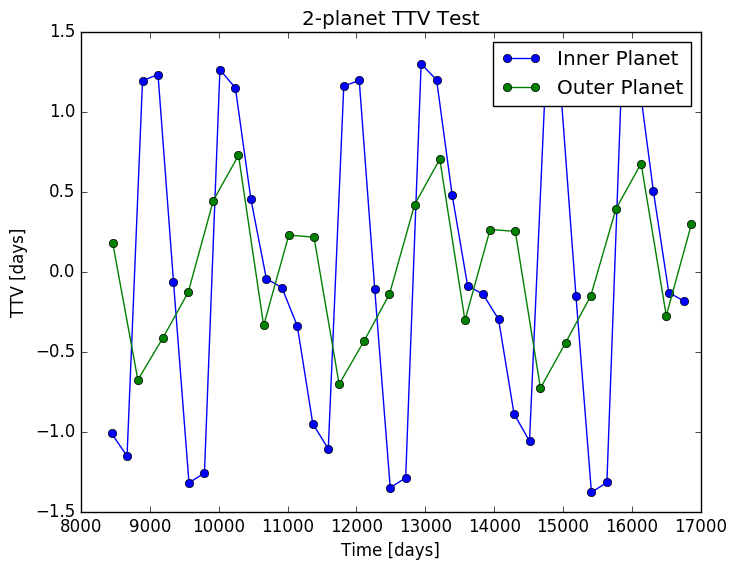

PyObject <matplotlib.legend.Legend object at 0x3253f7950>

In [23]:
# Test two planet ttv model
ttv1, ttv2 = two_planet_ttv_model(time1, time2, planets_test[1], planets_test[2]);
plot(time1, ttv1, "o-", label="Inner Planet")
plot(time2, ttv2, "o-", label="Outer Planet")
title("2-planet TTV Test")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

In [24]:
function construct_data_grid(t1, t2; N=2)
    if length(t1) > length(t2)
        n1 = length(t1)
        n2 = length(t2)
        x = t1
        y = t2
    else
        n1 = length(t2)
        n2 = length(t1)
        x = t2
        y = t1
    end
    
    dat = zeros(n1)
    
    # Populate y-grid
    for i=1:n2
        dat[i] = y[i]
    end
    
    # Preserve order
    if length(t1) > length(t2)
        data = [x dat]
    else
        data = [dat x]
    end
    
    # Add additional outer planets
    k = 2
    while k < N
        data = [data zeros(n1)]
        k += 1
    end
    
    return data
end

construct_data_grid (generic function with 1 method)

In [25]:
# 3 planet test

#planet1
MpMs1 = 0.0001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.0001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

p0 = [MpMs1,P1,t01,esw1,ecw1,
      MpMs2,P2,t02,esw2,ecw2];

data = construct_data_grid(time1, time2, N=2);

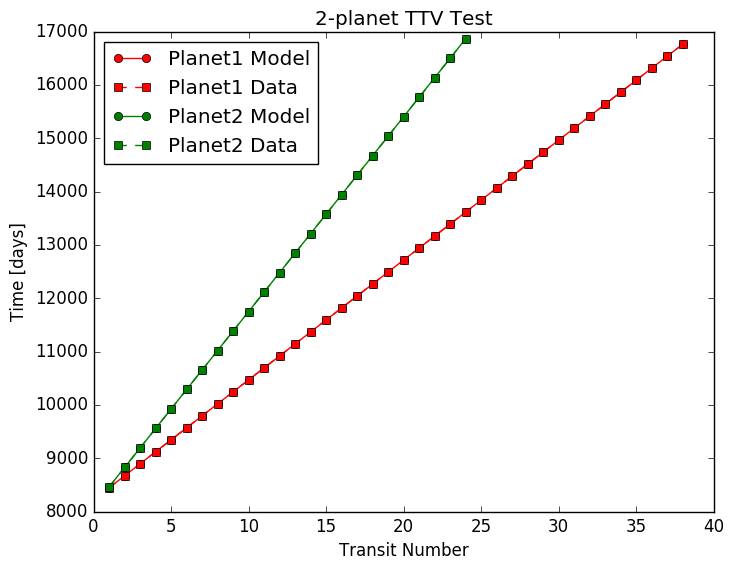

PyObject <matplotlib.text.Text object at 0x31dc6c8d0>

In [26]:
# Test N planet ttv model
p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
times_list = N_planet_ttv_model(data, p0);
# Plot Model & Data
plot(linspace(1,length(time1), length(time1)), times_list[1], "o-", c="r", label="Planet1 Model")
plot(linspace(1,length(time1), length(time1)), time1, "s--", c="r", label="Planet1 Data")
plot(linspace(1,length(time2), length(time2)), times_list[2], "o-", c="g", label="Planet2 Model")
plot(linspace(1,length(time2), length(time2)), time2, "s--", c="g", label="Planet2 Data")
ylabel("Time [days]")
xlabel("Transit Number")
legend(loc=2)
title("2-planet TTV Test")

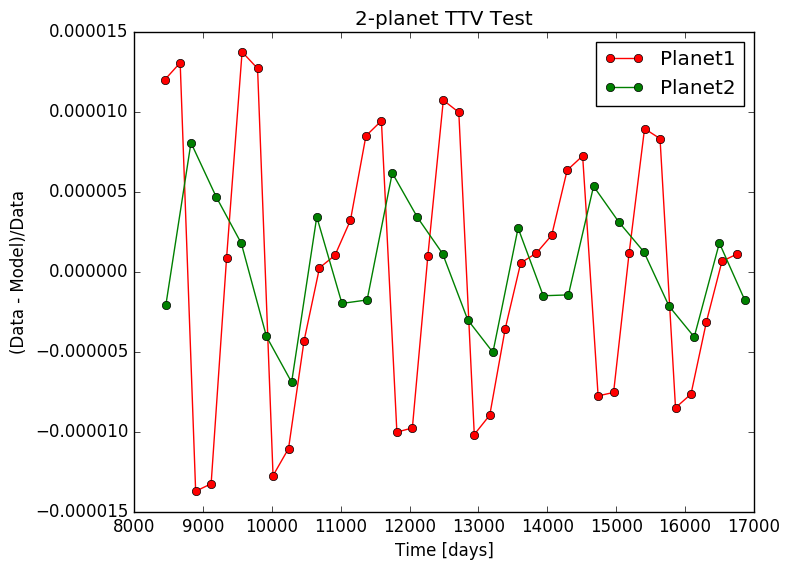

PyObject <matplotlib.text.Text object at 0x3256ee190>

In [27]:
# Test N planet ttv model
p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
times_list = N_planet_ttv_model(data, p0);
# Plot Model & Data
plot(time1, (time1 .- times_list[1])./time1, "o-", c="r", label="Planet1")
plot(time2, (time2 .- times_list[2])./time2, "o-", c="g", label="Planet2")
ylabel("(Data - Model)/Data")
xlabel("Time [days]")
legend(loc=0)
title("2-planet TTV Test")

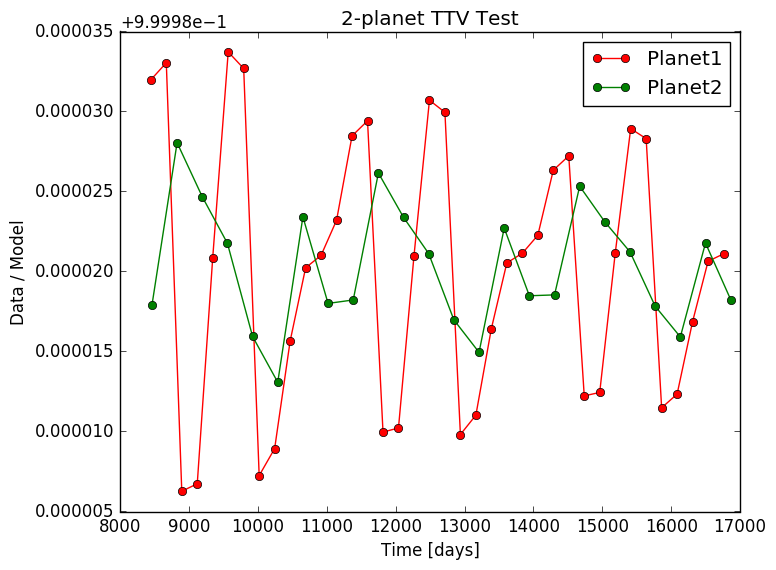

PyObject <matplotlib.text.Text object at 0x3287a3bd0>

In [28]:
# Test N planet ttv model
p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
times_list = N_planet_ttv_model(data, p0);
# Plot Model & Data
plot(time1, (time1 ./ times_list[1]), "o-", c="r", label="Planet1")
plot(time2, (time2 ./ times_list[2]), "o-", c="g", label="Planet2")
ylabel("Data / Model")
xlabel("Time [days]")
legend(loc=0)
title("2-planet TTV Test")

In [29]:
# 3 planet test

#planet1
MpMs1 = 0.0001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.0001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

#planet3
MpMs3 = 0.003
P3 = 5000.
t03 = 1.0
esw3 = 0.1
ecw3 = 0.1

p0 = [MpMs1,P1,t01,esw1,ecw1,
      MpMs2,P2,t02,esw2,ecw2, 
      MpMs3,P3,t03,esw3,ecw3];

data_in = construct_data_grid(time1, time2, N=3);

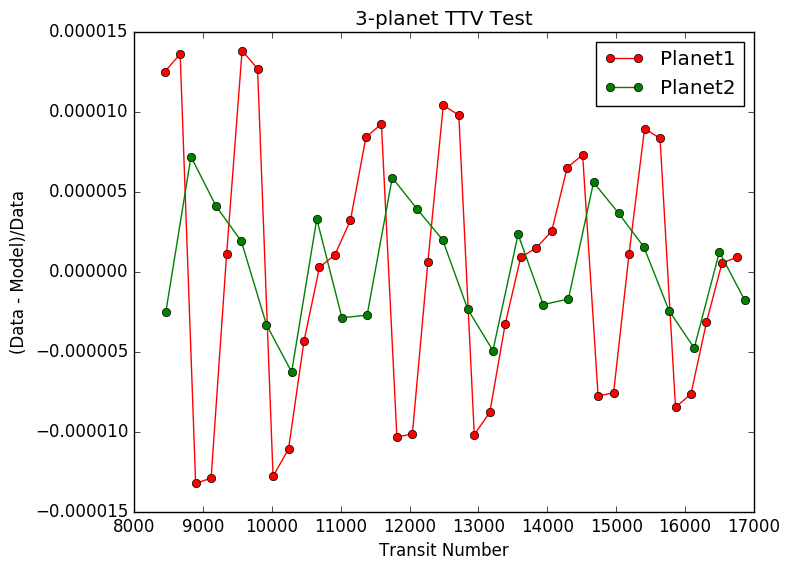

PyObject <matplotlib.text.Text object at 0x328c4b490>

In [30]:
# Test N planet ttv model
times_list = N_planet_ttv_model(data_in, p0);
# Plot Model & Data
plot(time1, (time1 .- times_list[1])./time1, "o-", c="r", label="Planet1")
plot(time2, (time2 .- times_list[2])./time2, "o-", c="g", label="Planet2")
ylabel("(Data - Model)/Data")
xlabel("Transit Number")
legend(loc=0)
title("3-planet TTV Test")

# Let's checkout `aimee`

In [31]:
include("aimee.jl")

est_burnin (generic function with 1 method)

In [32]:
(bestP1 - 0.001*bestP1), bestP1, (bestP1 + 0.001*bestP1)

(224.47606565221653,224.70076641863517,224.9254671850538)

In [33]:
function within_five_parameter_ttv_bounds(params::Vector)
    # params = [MpMs, P, t0, esw, ecw]
    global data
    
    # 0 < Masses < 10*Mj
    if (params[1] < 0.0) || (params[1] > 0.01)
        return false
    end
    # 0 < Periods < total observation duration
    if (params[2] < 0.0) || (params[2] > (data[end,1] - data[1,1]))
        return false
    end
    # 0 < t0 < current period
    if (params[3] < 0.0) || (params[3] > params[2])
        return false
    end
    # -1 < esin(w) < 1
    if (params[4] < -1.0) || (params[4] > 1.0)
        return false
    end
    # -1 < ecos(w) < 1
    if (params[5] < -1.0) || (params[5] > 1.0)
        return false
    end
    
    return true 
end

within_five_parameter_ttv_bounds (generic function with 1 method)

In [34]:
function within_hard_prior_bounds(params::Vector)
    return true
end 

within_hard_prior_bounds (generic function with 1 method)

In [35]:
i = 3
within_five_parameter_ttv_bounds(p0[((i-1)*5)+1:(i*5)])

true

In [36]:
function lnlike(data::Array{Float64,2},model::Function,params::Vector)
    # params = [MpMs1,P1,t01,esw1,ecw1,
    #           MpMs2,P2,t02,esw2,ecw2];
    
    # Are there 5 parameters for each planet?
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return Inf
    else
        # Number of planets
        N = Int(length(params) / 5)
    end

    # Get list of transit times for transiting planets
    times_data, transiting = deconstruct_data_grid(data; return_data=true);
    
    # --- Hard Bounds ---
    # Loop over planets
    for i=1:N
        # Check if ith planet params are within hard bounds
        in_bounds = within_five_parameter_ttv_bounds(params[((i-1)*5)+1:(i*5)])
        # If outside bounds, return Inf
        if ~ in_bounds
            return Inf
        end
    end
    
    # --- Priors ---   
    for i=1:N
        if transiting[i]
            # Compute period and std on period
            bestP, stdt = period_from_times(times_data[i])
            # Periods constrained by known mean period form data
            if ( params[5*(i-1)+2] < (bestP - stdt) ) || ( params[5*(i-1)+2] > (bestP + stdt) )
                return Inf
            end
        else
            # Check for user defined hard priors
            in_bounds = within_hard_prior_bounds(params)
            # If outside bounds, return Inf
            if ~ in_bounds
                return Inf
            end
        end 
    end 
    
    # Call model
    times_model = model(data, params);
    
    # Sum the sum-square-diffs for transiting planets
    res = 0.0
    for i=1:length(times_data)
        if transiting[i]
            res += sum((times_model[i] .- times_data[i]).^2);
        end
    end 
    
    return res
end

lnlike (generic function with 1 method)

In [37]:
#planet1
MpMs1 = 1e-6
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 1e-6
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

#planet3
MpMs3 = 0.003
P3 = 5000.
t03 = 1.0
esw3 = 0.1
ecw3 = 0.1

p0 = [MpMs1,P1,t01,esw1,ecw1,
      MpMs2,P2,t02,esw2,ecw2];

data_in = construct_data_grid(time1, time2, N=2);

In [38]:
function fit_model_two(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2];
    errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    return affine_inv_mcmc(nsteps,params,N_planet_ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model_two (generic function with 1 method)

In [39]:
N = 10000
pb, ll, nw, np = fit_model_two(N, data_in; verbose=false);

In [40]:
iburn = est_burnin(pb, nw, np, N)

4499

In [41]:
pavg = mean(vec(pb[1:nw,iburn:N,1]));
psig = std(vec(pb[1:nw,iburn:N,1]));
@printf "MpMs1: %8.5f +/- %8.5f\n" pavg psig

MpMs1:  0.00004 +/-  0.00005


In [42]:
length(pb[1,1,:])

10

In [101]:
function derived_parameters(chains, iburn; names=[], verbose=false)
    np = length(chains[1,1,:])
    nw = length(chains[:,1,1])
    mean_p = []
    std_p = []
    for i=1:np
        meantmp = mean(vec(chains[1:nw,iburn:end,i]))
        stdtmp = std(vec(chains[1:nw,iburn:end,i]))
        push!(mean_p, meantmp);
        push!(std_p, stdtmp);
        if names == []
            tmp = ""
        else
            tmp = names[i]
        end
        if verbose
            println(tmp,": $meantmp +/- $stdtmp")
        end
    end
    return mean_p
end

derived_parameters (generic function with 1 method)

In [44]:
names = ["MpMs1","P1","t01","esw1","ecw1","MpMs2","P2","t02","esw2","ecw2"];
mean_p2 = derived_parameters(pb, iburn, names=names, verbose=true)

MpMs1: 4.351325892789355e-5 +/- 5.496161375404705e-5
P1: 224.70074702553956 +/- 0.0013487958187382815
t01: 108.29598696890599 +/- 64.29941915951306
esw1: -0.028711198525262615 +/- 0.5424866706471816
ecw1: -0.07019543732771391 +/- 0.546068556329268
MpMs2: 5.404716568916841e-5 +/- 6.731039563036353e-5
P2: 365.2562641712237 +/- 0.001266747551820905
t02: 196.6201393776761 +/- 104.71639452366676
esw2: -0.024885492535501836 +/- 0.4711287216401568
ecw2: -0.034986735252269495 +/- 0.4715960912927391


10-element Array{Any,1}:
   4.35133e-5
 224.701     
 108.296     
  -0.0287112 
  -0.0701954 
   5.40472e-5
 365.256     
 196.62      
  -0.0248855 
  -0.0349867 

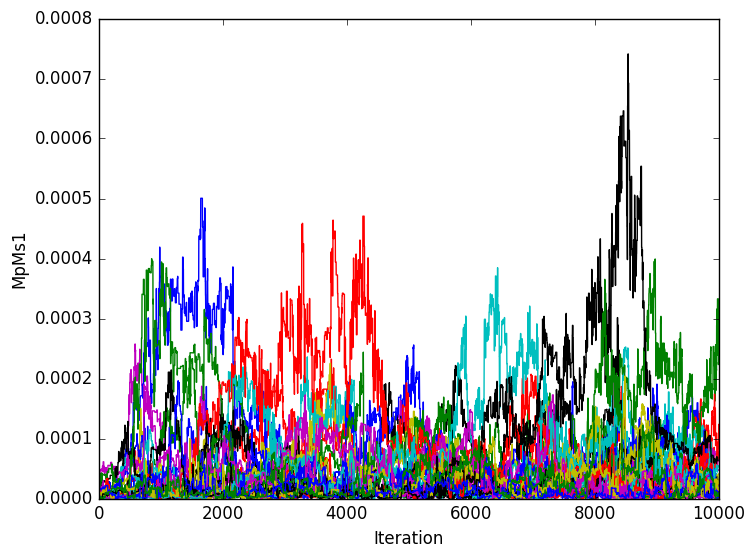

PyObject <matplotlib.text.Text object at 0x328ce6f90>

In [45]:
# Define names of parameters
names = ["MpMs1","P1","t01","esw1","ecw1","MpMs2","P2","t02","esw2","ecw2"];
# Create iteration grid for plot
x = collect(linspace(1, N, N))
which = 1
for i=1:nw
    plot(x, pb[i,:,which]')
end 
ylabel(names[which])
xlabel("Iteration")

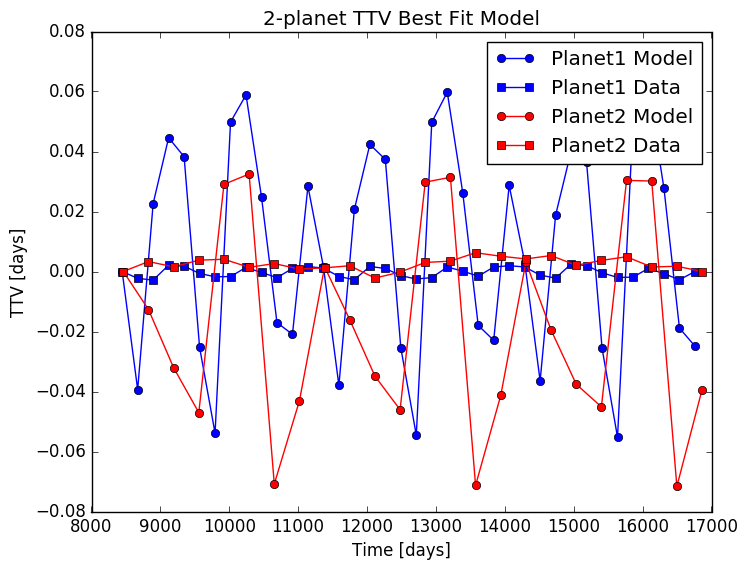

PyObject <matplotlib.legend.Legend object at 0x32be1f650>

In [46]:
# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, mean_p2);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

## Optim

In [47]:
function optim_lnlike(params::Vector)
    global data
    return lnlike(data,N_planet_ttv_model,params)
end

optim_lnlike (generic function with 1 method)

In [65]:
function optim_model_two(in_data::Array{Float64,2}, )
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.1
    ecw1 = 0.1

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.1
    ecw2 = 0.1
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2];
    #errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    optimum = optimize(optim_lnlike, params, iterations=5000, method=:simulated_annealing)

    return optimum.minimum
end

optim_model_two (generic function with 1 method)

In [68]:
@time optim_best = optim_model_two(data_in)

  0.106672 seconds (239.81 k allocations: 77.790 MB, 17.17% gc time)


10-element Array{Float64,1}:
   2.4e-6
 224.701 
   1.0   
  -0.1   
   0.1   
   3.0e-6
 365.256 
   1.0   
  -0.1   
   0.1   

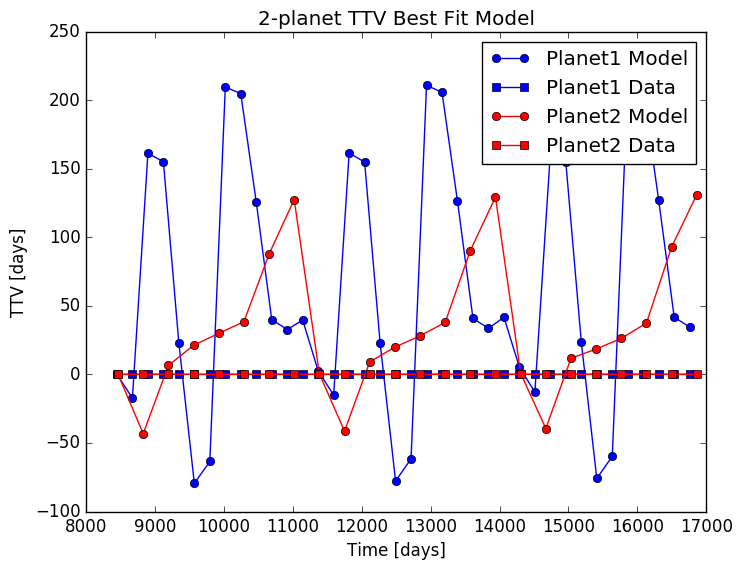

PyObject <matplotlib.legend.Legend object at 0x32cb1be50>

In [50]:
# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, optim_best);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

## Add 3rd planet
Loop over periods and phases to find best.

In [74]:
data_in = construct_data_grid(time1, time2, N=3);

In [99]:
function optim_model_three(in_data::Array{Float64,2}, )
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.01
    ecw1 = 0.01

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.01
    ecw2 = 0.01
    
    #planet3
    MpMs3 = 0.001
    P3 = 4333.
    t03 = 1.0
    esw3 = -0.01
    ecw3 = 0.01
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2,
              MpMs3,P3,t03,esw3,ecw3];
    #errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    optimum = optimize(optim_lnlike, params, iterations=5000, autodiff=false)

    return optimum.minimum
end

optim_model_three (generic function with 1 method)

In [100]:
@time optim_best = optim_model_three(data_in)

  0.139637 seconds (629.60 k allocations: 124.541 MB, 14.36% gc time)


15-element Array{Float64,1}:
    0.0625024
  224.763    
    1.0625   
    0.0525   
    0.0725   
    0.062503 
  365.319    
    1.0625   
    0.0525   
    0.0725   
    0.0635   
 4333.06     
    1.0625   
    0.0525   
    0.0725   

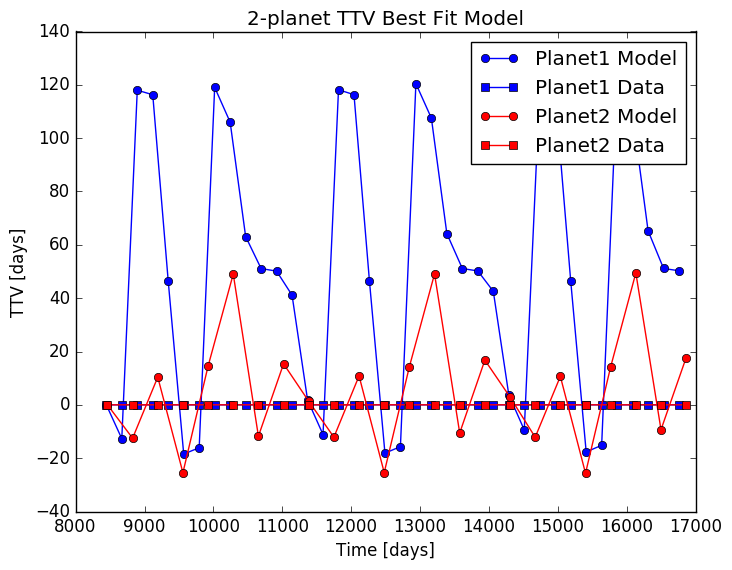

PyObject <matplotlib.legend.Legend object at 0x32af14750>

In [98]:
# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, optim_best);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

In [72]:
periods = collect(linspace(2000., 7000., 100));

In [103]:
function p3_period_loop()
    
    periods = collect(linspace(3500., 5500., 10));
    
    # Alloc memory for grid search
    p3_loglike = zeros(length(periods))

    # Loop over periods, calc loglike
    for i=1:length(periods)

        # Define phase grid
        phase = collect(linspace(0.0, periods[i], 10))
        tmpll = zeros(10)

        # Loop over phases
        for j=1:10

            #planet3 params
            MpMs3 = 0.001
            P3 = periods[i]
            t03 = phase[j]
            esw3 = 0.01
            ecw3 = -0.01

            p03 = [mean_p2, MpMs3,P3,t03,esw3,ecw3];

            data_in = construct_data_grid(time1, time2, N=3);
            
            #aimee
            N = 1000
            iburn = 900
            errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 
                0.000005, 0.0001, 1.0, 0.1, 0.1, 
                0.000005, 0.0001, 1.0, 0.1, 0.1];
            pb, ll, nw, np = affine_inv_mcmc(N,p03,N_planet_ttv_model,errors,verbose=false,lnlike=lnlike)
            meantmp = derived_parameters(pb, iburn, verbose=false)
            tmpll[j] = optim_lnlike(meantmp)
            
            # Optim
            #global data = data_in
            #optimum = optimize(optim_lnlike, p03, iterations=5000, method=:simulated_annealing)
            #tmpbest = optimum.minimum
            #tmpll[j] = optim_lnlike(tmpbest)


            #tmpll[j] = lnlike(data_in,N_planet_ttv_model,p03)
        end 

        p3_loglike[i] = minimum(tmpll)
    end 
    return p3_loglike
end 

p3_period_loop (generic function with 1 method)

In [104]:
p3_loglike = p3_period_loop()

10-element Array{Float64,1}:
 0.0790802
 0.0530458
 0.0694838
 0.0534434
 0.0668301
 0.06176  
 0.0875345
 0.0374562
 0.0668684
 0.0445465

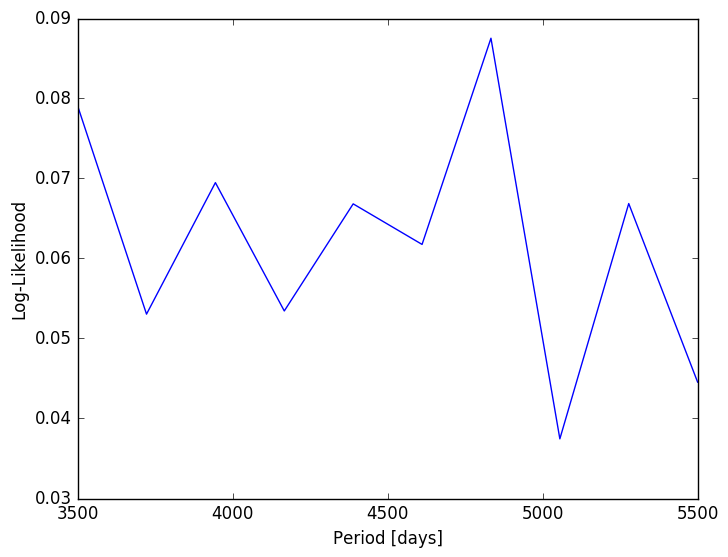

PyObject <matplotlib.text.Text object at 0x32ac47e90>

In [106]:
periods = collect(linspace(3500., 5500., 10));

# Test two planet ttv model
plot(periods, p3_loglike, "-")
title("")
xlabel("Period [days]")
ylabel("Log-Likelihood")

In [ ]:
function argmin(x::Array{Float64,1}; MIN::Float64=1.0e-10)
  """
  Returns index of minimum value in x
  """
    for i=1:length(x)
        if abs(x[i] - minimum(x)) < MIN
            return i
        end
    end
end

In [ ]:
i = argmin(p3_loglike)

In [ ]:
periods[i]

In [107]:
function fit_model_three(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.01
    ecw1 = 0.01

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.01
    ecw2 = 0.01
    
    #planet3
    MpMs3 = 0.001
    P3 = 4332.8
    t03 = 1.0
    esw3 = -0.01
    ecw3 = 0.01
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2,
              MpMs3,P3,t03,esw3,ecw3];
    errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    return affine_inv_mcmc(nsteps,params,N_planet_ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model_three (generic function with 1 method)

In [108]:
data_in = construct_data_grid(time1, time2, N=3);

In [109]:
N = 10000
pb, ll, nw, np = fit_model_three(N, data_in; verbose=false);

In [110]:
iburn = est_burnin(pb, nw, np, N)

8078

In [111]:
names = ["MpMs1","P1","t01","esw1","ecw1",
    "MpMs2","P2","t02","esw2","ecw2",
    "MpMs3","P3","t03","esw3","ecw3"];
mean_p3 = derived_parameters(pb, iburn, names=names, verbose=true)

MpMs1: 8.014815545246011e-5 +/- 0.00016965805145012527
P1: 224.70102591952707 +/- 0.0013402750288388514
t01: 121.260091972777 +/- 55.96874834742528
esw1: 0.024393039743143104 +/- 0.5505696687231453
ecw1: -0.06048079335122586 +/- 0.5170170152852747
MpMs2: 8.246447115479579e-5 +/- 0.00010217729260097579
P2: 365.2562992718036 +/- 0.0012282063232876635
t02: 198.81322063857928 +/- 108.77951605045102
esw2: 0.08970574775825539 +/- 0.4612113267064186
ecw2: -0.029392341721458087 +/- 0.46603106311187187
MpMs3: 0.004780046439219204 +/- 0.003047352038364455
P3: 4336.959146962042 +/- 21.82040056415262
t03: 917.4344812110717 +/- 856.602862033643
esw3: -0.03146814913816033 +/- 0.578047792826449
ecw3: -0.07613110229900072 +/- 0.592454670012549


15-element Array{Any,1}:
    8.01482e-5
  224.701     
  121.26      
    0.024393  
   -0.0604808 
    8.24645e-5
  365.256     
  198.813     
    0.0897057 
   -0.0293923 
    0.00478005
 4336.96      
  917.434     
   -0.0314681 
   -0.0761311 

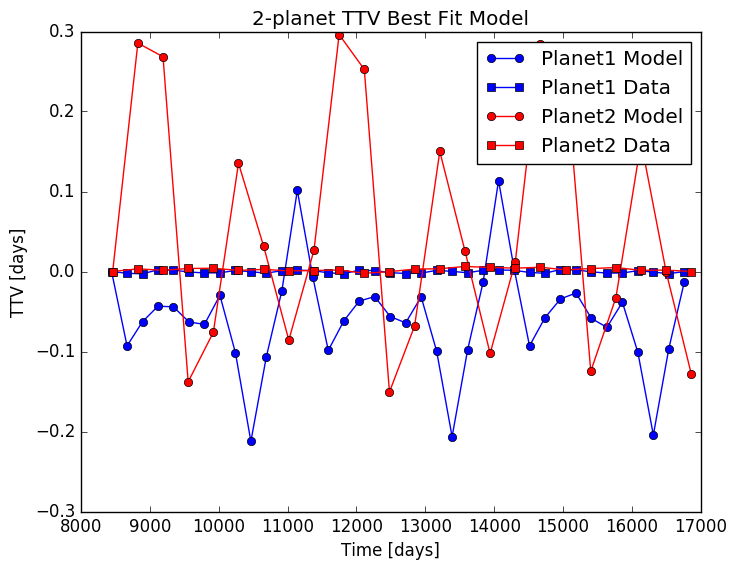

PyObject <matplotlib.legend.Legend object at 0x327fb97d0>

In [112]:
# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, mean_p3);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)